In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers

In [4]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


In [27]:
grid_outlook_location = 'data/outlooks/grid_outlooks.nc'
grid_report_location = 'data/storm_reports/grid_reports.nc'

grid_outlooks = xr.open_dataset(grid_outlook_location)
grid_reports = xr.open_dataset(grid_report_location)

In [204]:
def plot_outlooks_day(outlooks_date, output_location, categories, title_date, show=False, save = True):
    # plots day 1, 2, and 3 outlooks for a day of given categories (hail, wind, tornado, categorical)
    outlooks_date['PRODISS'] = parse_datetime(outlooks_date['PRODISS'])
    for category in categories:
        outlooks_category = outlooks_date[outlooks_date['CATEGORY'] == category]
        for day in [[3, 8], [2, 7], [2, 17], [1, 6]]: 
            outlooks_category_day = outlooks_category[(outlooks_category['DAY'] == day[0]) & (outlooks_category['CYCLE'] == day[1])]
            latest_issue_time = np.max(outlooks_category_day['PRODISS'])
            outlooks_category_day = outlooks_category_day[outlooks_category_day['PRODISS'] == latest_issue_time]
            if outlooks_category_day.empty == False:
                fig=plt.figure(figsize=(9,6))
                plt.style.use('dark_background')
                ax = plt.axes(projection = cp.crs.LambertConformal())
                ax.add_feature(cp.feature.LAND,facecolor='grey')
                ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
                ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
                ax.add_feature(cp.feature.LAKES, alpha = 0.5)
                ax.add_feature(cp.feature.STATES,linewidth=0.5)
                outlooks_category_day.plot('THRESHOLD', legend = True)
                plt.title(title_date + ' Day ' + str(day) + ' ' + category + ' outlook for ' + str(outlooks_category_day['DATE'].iloc[0]))
                cx.add_basemap(ax, crs=outlooks_category_day.crs)
                if save:
                    plt.savefig(output_location + '/day' + str(day) + '_' + category + '_' + str(outlooks_category_day['DATE'].iloc[0]) + '.png')
                if not show:
                    plt.close()

def plot_grid_outlooks_day(grid_outlooks_date, output_location, title_date, show=False, save = True):
    # plots day 3, day 2, and day 2 outlooks for a day. Assume that grid_outlooks_date only contains one day
    for day in ['Day 3', 'Day 2 7', 'Day 2 17', 'Day 1']: 
        grid_outlooks_date_outlook = grid_outlooks_date.sel(outlook = day)
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:],
                    levels=[0,.02], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:]+.01,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            
        except:
            plt.annotate("No Severe Thunderstorms Forecast", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
        
        ax.set_extent([-121, -71, 23, 50])
        plt.title(title_date + ' ' + day + ' Any-Hazard Outlook')
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if save:
            plt.savefig(output_location + '/pph_' + str.replace(day, ' ', '_') + '.png')
        if not show:
            plt.close()

def plot_pph_day(pph_date, output_location, categories, title_date, show = False, save = True, sig = True):
    for category in categories:
        pph_date_category = pph_date[['p_perfect_' + category, 'lat', 'lon']]
        if sig:
            pph_date_category_sig = pph_date[['p_perfect_sig_' + category, 'lat', 'lon']]

        
        # credit: https://atlas.niu.edu/pperfect/BAMS/notebook_sample.html
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[0,2], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:],
                    levels=[2,5,10,15,30,45,60,100], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            plt.annotate('PPER Max\n'+str(pph_date_category['p_perfect_' + category].values[:,:].max().round(1))+'%', xy=(0.88, 0.3), xycoords="figure fraction",
                        va="center", ha="center", color='white',fontsize=12,
                        bbox=dict(boxstyle="round", fc="k"))
        except:
            plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
            
        if sig:    
            try:
                plt.contourf(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors='none', hatches=['////'],
                        transform=cp.crs.PlateCarree())
                plt.contour(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors=['k'],
                        transform=cp.crs.PlateCarree())
            except:
                pass

        if category == 'tor':
            cat_title = 'Tornado'
        elif category == 'hail':
            cat_title = 'Hail'
        elif category == 'wind':
            cat_title = 'Wind'
        else:
            cat_title = 'All Hazards'

        ax.set_extent([-121, -71, 23, 50])
        plt.title(title_date + ' 24 Hour Practically Perfect Hindcast for ' + cat_title)
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if save:
            plt.savefig(output_location + '/pph_' + category + '.png')
        if not show:
            plt.close()

def plot_reports(reports, output_location, categories, title_date, show = False, save = True):
    # plots all storm reports in reports
    legend = []
    fig=plt.figure(figsize=(9,6))
    plt.style.use('dark_background')
    ax = plt.axes(projection = cp.crs.LambertConformal())
    ax.add_feature(cp.feature.LAND,facecolor='grey')
    ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cp.feature.LAKES, alpha = 0.5)
    ax.add_feature(cp.feature.STATES,linewidth=0.5)

    for category in categories:
        reports_category = reports[reports['EVENT_TYPE'] == category]
        reports_category = reports_category[reports_category['BEGIN_LAT'] != '']
        reports_category = reports_category[reports_category['BEGIN_LON'] != '']

        m1 = '.'
        # remove sub-severe
        if category == 'Hail':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 2.0]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 1.0) & (reports_category['MAGNITUDE'].astype(float) < 2.0)]
            if not reports_category.empty:
                c1 = 'LimeGreen'
                legend.append('Hail')
            if not reports_sig.empty:
                c2 = 'DarkGreen'
                m2 = '^'
                legend.append('Sig Hail')

        elif category == 'Thunderstorm Wind':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 65]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 50) & (reports_category['MAGNITUDE'].astype(float) <65)]
            
            if not reports_category.empty:
                c1 = 'Blue'
                legend.append('Wind')
            if not reports_sig.empty:
                c2 = 'DarkBlue'
                m2 = ','
                legend.append('Sig Wind')
            
            
        else:
            reports_sig = reports_category[[(cat[-1] != 'U' and cat[-1] != '0' and cat[-1] != '1') for cat in reports_category['TOR_F_SCALE']]]
            reports_category = reports_category[[(cat[-1] == 'U' or cat[-1] == '0' or cat[-1] == '1') for cat in reports_category['TOR_F_SCALE']]]
            
            if not reports_category.empty:
                c1 = 'Red'
                legend.append('Tornado')
            if not reports_sig.empty:  
                c2 = 'DarkRed'
                m2 = 'v'
                legend.append('Sig Tornado')
        

        # plot severe
        if not reports_category.empty:
            ax.scatter(reports_category['BEGIN_LON'].values.astype(float), reports_category['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m1, color = c1)
        if not reports_sig.empty:
            ax.scatter(reports_sig['BEGIN_LON'].values.astype(float), reports_sig['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m2, color = c2)


    plt.title(title_date + ' Storm Reports')
    plt.legend(legend)
    if save:
        plt.savefig(output_location + '/report_' + category + '.png')
    if not show:
        plt.close()

In [205]:
# TODO: make function that plots all 3 outlooks, PPH, and reports for one day to spotcheck
# with utils_plotting functions
def plot_day(datestring, grid_outlooks, pph, reports, show = True, save = False):
    grid_outlooks_day = grid_outlooks.sel(time=datestring)
    pph_day = pph.sel(time=datestring)
    reports_day = reports[reports['DATE'] == datestring]

    titledate = dt.strptime(datestring, "%Y%m%d%H%M").strftime("%m/%d/%Y")

    # TODO: automatically build save location folders if needed
    
    print('plotting outlooks')
    plot_grid_outlooks_day(grid_outlooks_day, 'plots/daily/'+datestring+'/outlooks', titledate, show = show, save = save)
    print('plotting pph')
    plot_pph_day(pph_day, 'plots/daily/'+datestring+'/pph', ['total'], titledate, show=show, save = save, sig = False)
    print('plotting reports')
    plot_reports(reports_day, 'plots/daily/'+datestring+'/reports', ['Hail', 'Thunderstorm Wind', 'Tornado'], titledate, show=show, save = save)
    
    labels = ['MAX_CAT', 'RAMP_UP', 'RAMP_DOWN', 'RAMP_CAT', 'SEASON', 'REGION', 'PPH_CAT', 'PPH_NUM', 'REPORT_NUM', 'TOR_NUM', 'WIND_NUM', 'HAIL_NUM', 'TOR_F', 'WINDSP_CAT', 'WINDSP_NUM', 'HAILSZ_CAT', 'HAILSZ_NUM', 'NEIGH_NUM', 'RMSE_NUM', 'BS_NUM']
    for label in labels:
        print(label +  ': ' + str(pph_day[label].data))
        # TODO: add to txt and save
    return


plotting outlooks
plotting pph
plotting reports
MAX_CAT: HIGH
RAMP_UP: 1
RAMP_DOWN: 0
RAMP_CAT: up
SEASON: Spring
REGION: South
PPH_CAT: HIGH
PPH_NUM: 94.55788058460172
REPORT_NUM: 790
TOR_NUM: 284
WIND_NUM: 330
HAIL_NUM: 176
TOR_F: (E)F5
WINDSP_CAT: sig_severe
WINDSP_NUM: 87.0
HAILSZ_CAT: sig_severe
HAILSZ_NUM: 4.0
NEIGH_NUM: 0.0033886856575682384
RMSE_NUM: 0.041105495040614934
BS_NUM: 0.012824714640198511


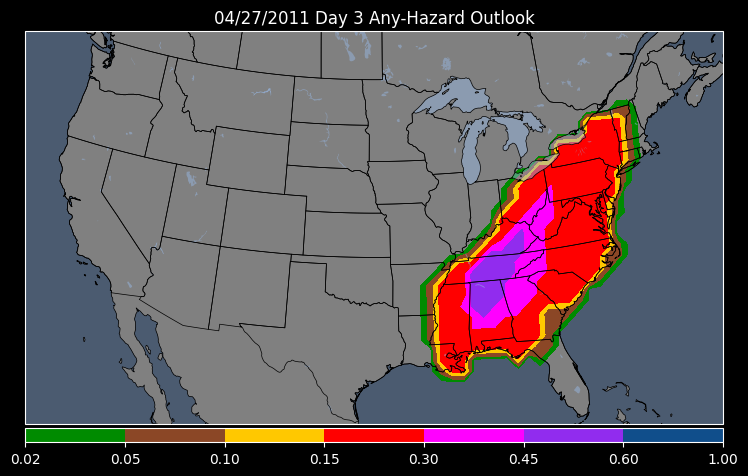

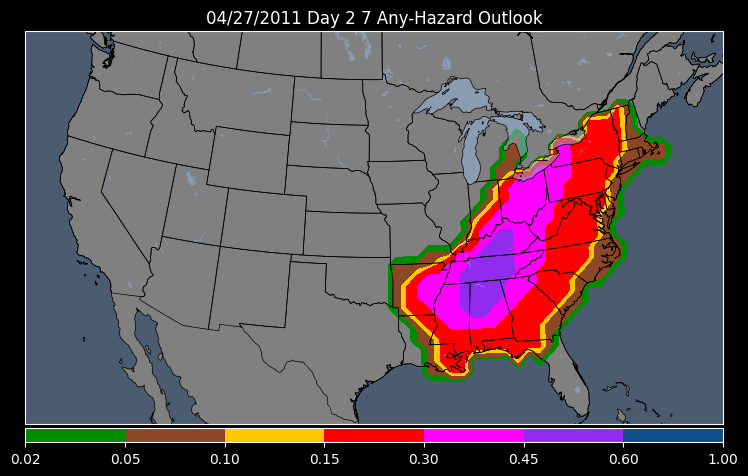

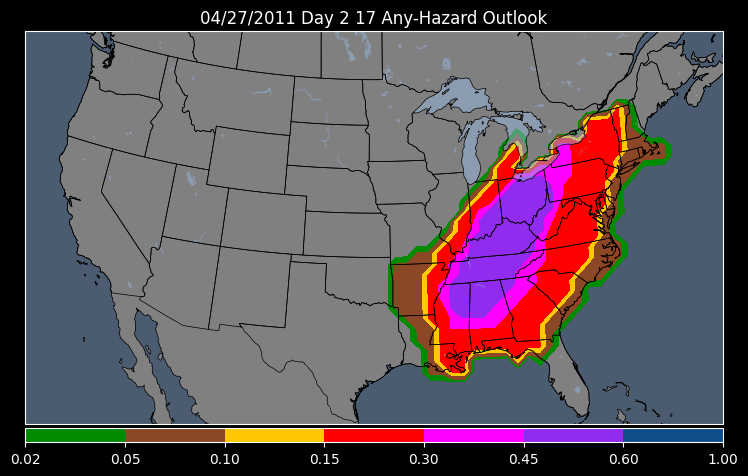

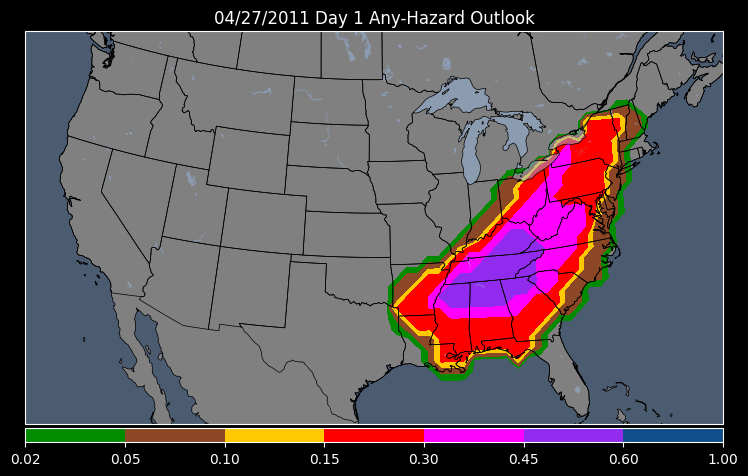

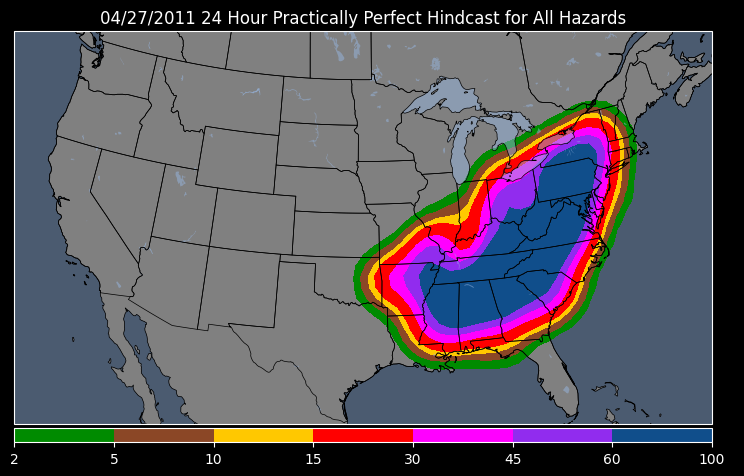

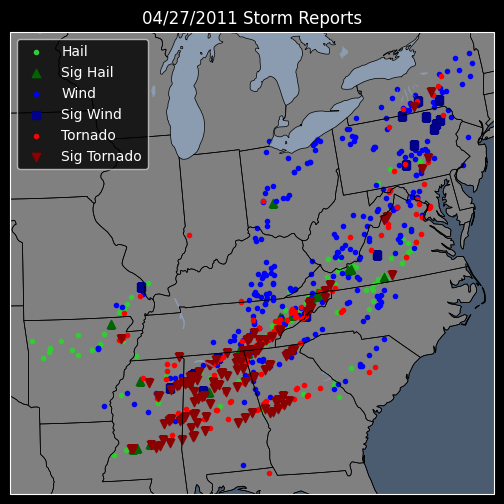

In [206]:
date_of_interest = '201104270000'
plot_day(date_of_interest, grid_outlooks, pph, reports)